In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
def pdf_fig(figure, filename):
    figure = figure.get_figure()
    figure.savefig("../../thesis/img/big-study/" + filename + ".pdf", bbox_inches = "tight")

In [4]:
# seaborn styling
sns.set_style("darkgrid")
sns.set_palette(sns.husl_palette(h=.5, s=1))
sns.set_context("talk")
sns.set(rc={'figure.figsize':(10,4),
            'legend.fontsize':16,
            'legend.title_fontsize':17,
            'xtick.labelsize':16,
            'ytick.labelsize':16,
            'axes.labelsize':16})

def label_bars_ints(ax, fontsize=14):
    for p in ax.patches:
        ax.annotate("%.0i" % np.nan_to_num(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=fontsize, color='black', xytext=(0, 10),
            textcoords='offset points')

def label_bars_floats(ax, fontsize=14):
    for p in ax.patches:
        if p.get_width() == 0:
            continue
        ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=fontsize, color='black', xytext=(0, 10),
            textcoords='offset points')
        ax.hlines(p.get_height(), p.get_x(), p.get_x() + p.get_width())

def process_fig(ax, name, technique, int_annotation, hue_title, labels=[], fontsize=14):
    if (int_annotation):
        label_bars_ints(ax, fontsize)
    else:
        label_bars_floats(ax, fontsize)
    if (hue_title != ''):
        if (labels != []):
            handles, x = ax.get_legend_handles_labels()
            ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1.02, 0.5), title=hue_title, labels=labels)
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), title=hue_title)
    pdf_fig(ax, name + '-' + technique)
    plt.show()
    ax.clear()

In [5]:
plt.rcParams.keys()

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning:


examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.



KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [6]:
techniques = ['PBE', 'CTS', 'KWS', 'RLR']
bool_order = [True, False]
pr_labels= ['Precision', 'Recall', 'F1 Score']

In [7]:
pbe = pd.read_csv('pbe.csv')
pbe['Technique'] = 'PBE'
ir = pd.read_csv('ir.csv')
ir['Technique'] = 'CTS'
kw = pd.read_csv('keyword.csv')
kw['Technique'] = 'KWS'
rn = pd.read_csv('random.csv')
rn['Technique'] = 'RLR'
frames = [pbe, ir, kw, rn]

In [8]:
# repair test input line count of cts
rn_dict = rn.set_index('TestInputPath')['TestInputLineCount'].to_dict()
ir['TestInputLineCount'] = ir.apply(lambda x: rn_dict[x['TestInputPath']], axis=1)

In [9]:
result_big = pd.concat(frames)
result_big.rename(columns={'Unnamed: 0':'v',
                       'Accuracy':'String Distance',
                       'TestOutput':'Test Output',
                       'DesiredTestOutput':'Desired Test Output',
                       'ExampleCount':'Example Count',
                       'TestInputLineCount':'Test Input Line Count',
                       'TestCategory':'Test Category',
                       'ContextSizeFactor':'Retrieval Size Factor',
                       'LearningDuration':'Learning Duration',
                       'ApplicationDuration':'Application Duration'}, inplace=True)

In [10]:
def calc_overlapping_lines(row):
    lines_desired = str(row['Desired Test Output']).splitlines()
    lines_output = str(row['Test Output']).splitlines()
    overlap = list((Counter(lines_output) & Counter(lines_desired)).elements())
    row['Output Lines Count'] = len(lines_output)
    if (row['Output Lines Count'] > row['Test Input Line Count']):
        row['Output Lines Count'] = row['Test Input Line Count']
    row['Desired Lines Count'] = len(lines_desired)
    row['True Positives Count'] = len(overlap)
    row['False Positives Count'] = row['Output Lines Count'] - len(overlap)
    row['False Negatives Count'] = len(lines_desired) - len(overlap)
    return row

result_big = result_big.apply(calc_overlapping_lines, axis=1)                
#result_big.loc[result_big['Output Lines Count'] > result_big['Test Input Line Count'], 'Output Lines Count'] = result_big['Test Input Line Count']
                              
result_big['True Negatives Count'] = result_big['Test Input Line Count'] - (result_big['Output Lines Count'] + result_big['False Negatives Count'])
result_big['All Desired Lines Extracted'] = result_big['False Negatives Count'] == 0
result_big['Precision'] = result_big['True Positives Count'] / result_big['Output Lines Count']
result_big.loc[(result_big['Technique'] == 'PBE') & (result_big['Test Output'].isin(['no program found', 'no extraction found for this input'])), 'Precision'] = 1
result_big['Recall'] = result_big['True Positives Count'] / result_big['Desired Lines Count']
result_big['Accuracy'] = (result_big['True Positives Count'] + result_big['True Negatives Count']) / result_big['Test Input Line Count']
result_big['Ratio of Lines Retrieved'] = result_big['Output Lines Count'] / result_big['Test Input Line Count']
result_big['F1 Score'] = 2 * ((result_big['Precision'] * result_big['Recall']) / (result_big['Precision'] + result_big['Recall']))
result_big['False Positive Rate'] = result_big['False Positives Count'] / (result_big['Test Input Line Count'] - result_big['Desired Lines Count'])



def category_count(categories, test_cat):
    cats = set(categories.split('-'))
    cats.add(str(test_cat))
    return len(cats)

result_big['Category Count'] = result_big.apply(lambda x : category_count(x['Categories'], x['Test Category']), axis=1)
result_big['Single Category'] = result_big['Category Count'] == 1

result_big.head()

,v,Example Count,LearnedProgram,TestInputPath,Test Output,Desired Test Output,String Distance,IoU,Successful,Learning Duration,...,True Negatives Count,All Desired Lines Extracted,Precision,Recall,Accuracy,Ratio of Lines Retrieved,F1 Score,False Positive Rate,Category Count,Single Category
0,1,1,"let s = v in let s = StartToPosRegion(s, Regex...",../tool/samples/C#/NancyFx@Nancy/failed/375800...,no extraction found for this input,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.027049,0.0,False,00.24.078,...,3226,False,1.0,0.0,0.990786,0.000307,0.0,0.000310,2,False
1,2,2,NaN,../tool/samples/C#/NancyFx@Nancy/failed/377324...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012882,0.0,False,00.08.105,...,3080,False,1.0,0.0,0.994832,0.000323,0.0,0.000325,2,False
2,3,3,NaN,../tool/samples/C#/NancyFx@Nancy/failed/382556...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012739,0.0,False,00.12.899,...,3110,False,1.0,0.0,0.994882,0.000320,0.0,0.000321,2,False
3,4,4,NaN,../tool/samples/C#/NancyFx@Nancy/failed/386536...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012739,0.0,False,00.17.907,...,3065,False,1.0,0.0,0.994807,0.000325,0.0,0.000326,2,False
4,5,5,NaN,../tool/samples/C#/NancyFx@Nancy/failed/405164...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012882,0.0,False,00.22.948,...,3071,False,1.0,0.0,0.994817,0.000324,0.0,0.000326,2,False


In [11]:
result_big.dtypes

v                                int64
Example Count                    int64
LearnedProgram                  object
TestInputPath                   object
Test Output                     object
Desired Test Output             object
String Distance                float64
IoU                            float64
Successful                        bool
Learning Duration               object
Application Duration            object
SearchKeywords                  object
AllKeywords                     object
Categories                      object
Test Input Line Count            int64
Test Category                    int64
Retrieval Size Factor          float64
Technique                       object
Output Lines Count               int64
Desired Lines Count              int64
True Positives Count             int64
False Positives Count            int64
False Negatives Count            int64
True Negatives Count             int64
All Desired Lines Extracted       bool
Precision                

In [12]:
result = result_big[result_big['Retrieval Size Factor'] == 1]
result

,v,Example Count,LearnedProgram,TestInputPath,Test Output,Desired Test Output,String Distance,IoU,Successful,Learning Duration,...,True Negatives Count,All Desired Lines Extracted,Precision,Recall,Accuracy,Ratio of Lines Retrieved,F1 Score,False Positive Rate,Category Count,Single Category
0,1,1,"let s = v in let s = StartToPosRegion(s, Regex...",../tool/samples/C#/NancyFx@Nancy/failed/375800...,no extraction found for this input,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.027049,0.000000,False,00.24.078,...,3226,False,1.000000,0.000000,0.990786,0.000307,0.000000,0.000310,2,False
1,2,2,NaN,../tool/samples/C#/NancyFx@Nancy/failed/377324...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012882,0.000000,False,00.08.105,...,3080,False,1.000000,0.000000,0.994832,0.000323,0.000000,0.000325,2,False
2,3,3,NaN,../tool/samples/C#/NancyFx@Nancy/failed/382556...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012739,0.000000,False,00.12.899,...,3110,False,1.000000,0.000000,0.994882,0.000320,0.000000,0.000321,2,False
3,4,4,NaN,../tool/samples/C#/NancyFx@Nancy/failed/386536...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012739,0.000000,False,00.17.907,...,3065,False,1.000000,0.000000,0.994807,0.000325,0.000000,0.000326,2,False
4,5,5,NaN,../tool/samples/C#/NancyFx@Nancy/failed/405164...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012882,0.000000,False,00.22.948,...,3071,False,1.000000,0.000000,0.994817,0.000324,0.000000,0.000326,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1,1,1,VimL/neovim@neovim/failed/567659224.log,[34/132] Building C object src/nvim/CM...les/n...,ERROR: AddressSanitizer: SEGV on unknown addre...,0.008036,0.000000,False,00.00.002,...,9793,False,0.000000,0.000000,0.990994,0.000101,NaN,0.000102,2,False
396,2,2,44.5,VimL/neovim@neovim/failed/567670361.log,[32m[2m[ RUN ][0m[0m clipboard (with fake...,ERROR: AddressSanitizer: SEGV on unknown addre...,0.173288,0.007634,False,00.00.000,...,9785,False,0.022727,0.011364,0.986890,0.004437,0.015152,0.004375,2,False
397,3,3,59,VimL/neovim@neovim/failed/567681636.log,[32m[2m[ RUN ][0m[0m ShaDa support code d...,ERROR: AddressSanitizer: SEGV on unknown addre...,0.179061,0.000000,False,00.00.000,...,9734,False,0.000000,0.000000,0.985123,0.005971,NaN,0.006025,2,False
398,4,4,66.25,VimL/neovim@neovim/failed/567681970.log,[109/132] Building C object src/nvim/CMakeFile...,ERROR: AddressSanitizer: SEGV on unknown addre...,0.173628,0.000000,False,00.00.000,...,9714,False,0.000000,0.000000,0.984394,0.006688,NaN,0.006748,2,False


In [13]:
def rtf(result,technique):
    return result[result['Technique'] == technique]

In [14]:
rtf(result, 'CTS')['Test Input Line Count']

0       1384
1       1382
2      10486
3       6657
4       5327
       ...  
395     9882
396     9916
397     9881
398     9868
399    10193
Name: Test Input Line Count, Length: 400, dtype: int64

In [15]:
# recall and precision in one figure
rcpr_big = pd.melt(result_big,
                   id_vars=['Example Count', 'Technique', 'Category Count', 'Retrieval Size Factor', 'Test Category', 'Test Output'],
                   value_vars=['Precision', 'Recall', 'F1 Score'],
                   var_name='Measurement',
                   value_name='Value')
rcpr_big
rcpr = rcpr_big[rcpr_big['Retrieval Size Factor'] == 1]
rcpr.head()

,Example Count,Technique,Category Count,Retrieval Size Factor,Test Category,Test Output,Measurement,Value
0,1,PBE,2,1.0,1,no extraction found for this input,Precision,1.0
1,2,PBE,2,1.0,1,no program found,Precision,1.0
2,3,PBE,2,1.0,1,no program found,Precision,1.0
3,4,PBE,2,1.0,1,no program found,Precision,1.0
4,5,PBE,2,1.0,1,no program found,Precision,1.0


In [16]:
def fancy_pr_plot(x, data):
    ax = sns.barplot(x=x, y='Value', hue='Measurement', data=data,
                     fill=False, linewidth=0, ci=None)
    sns.violinplot(x=x, y='Value', hue='Measurement', data=data,
                   inner=None, scale_hue=True,
                   linewidth=0, split=False,
                   cut=0, scale='width', saturation=1,
                   dodge=True, palette=['#f781bf','#dede00', '#60bb5d'])
    return ax

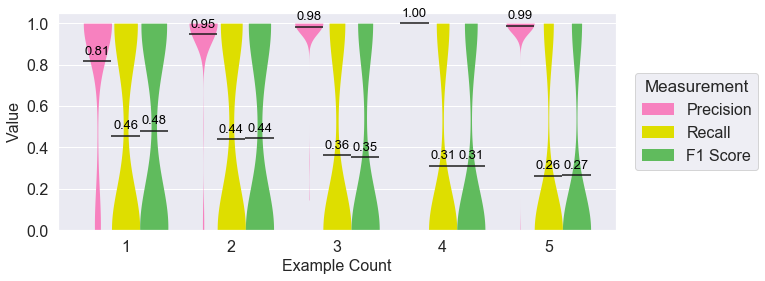

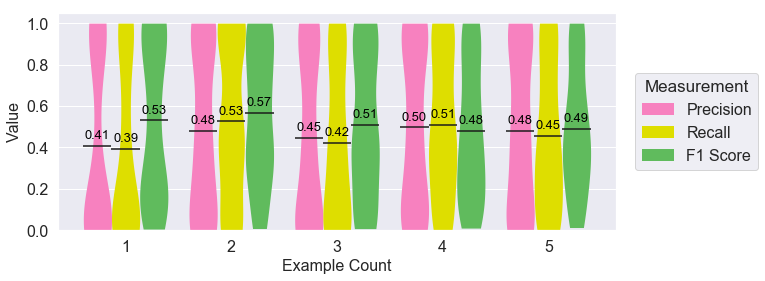

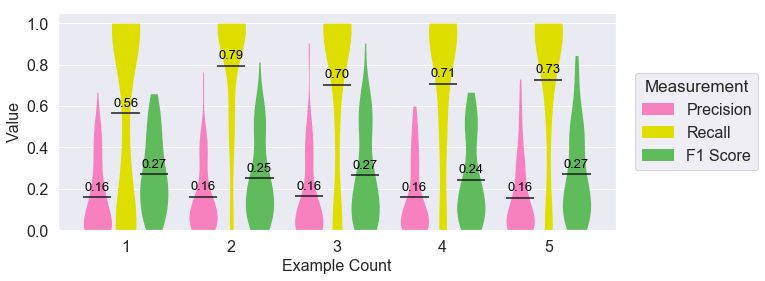

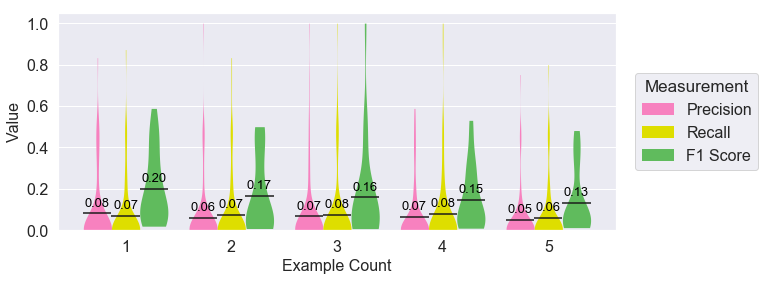

In [17]:
# precision and recall against examplecount
def precision_recall_examplecount(technique):
    ax = fancy_pr_plot('Example Count', rtf(rcpr, technique))
    process_fig(ax, 'recall-precision-examplecount', technique, False, 'Measurement', labels=pr_labels, fontsize=13)
    
for technique in techniques:
    precision_recall_examplecount(technique)

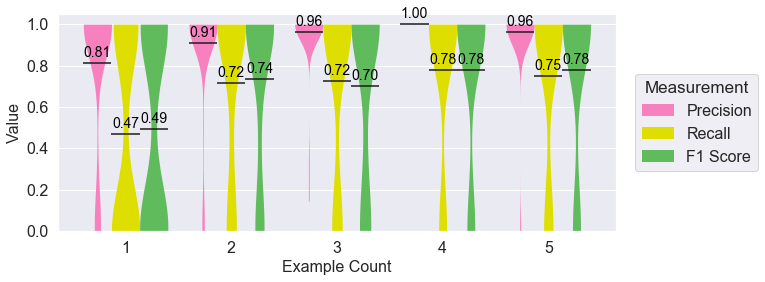

In [18]:
# precision and recall against examplecount synthesis worked
def precision_recall_examplecount(technique):
    ax = fancy_pr_plot('Example Count', rtf(rcpr[rcpr['Test Output'] != 'no program found'], technique))
    process_fig(ax, 'recall-precision-examplecount-sythesisworked', technique, False, 'Measurement', labels=pr_labels)
    
precision_recall_examplecount('PBE')

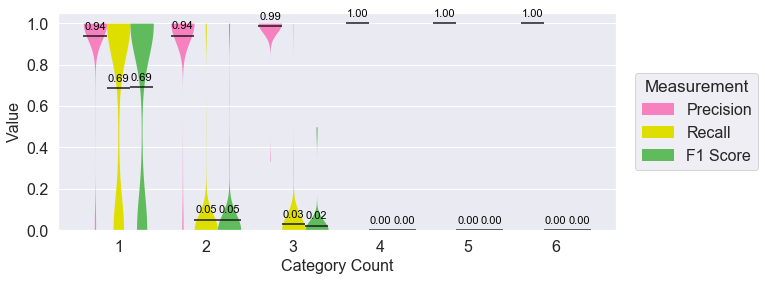

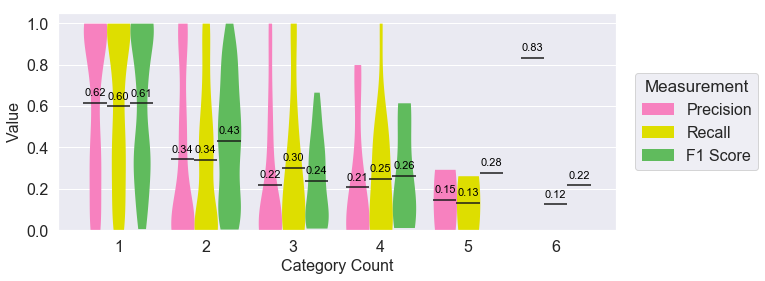

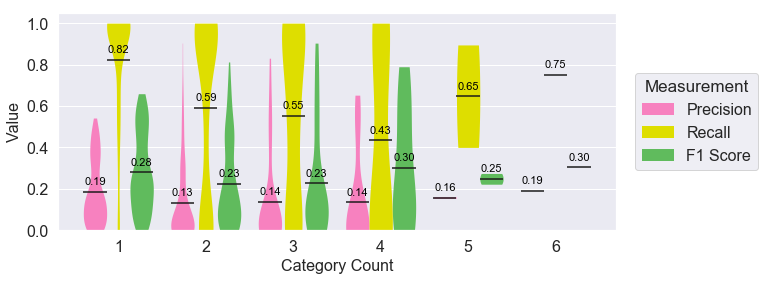

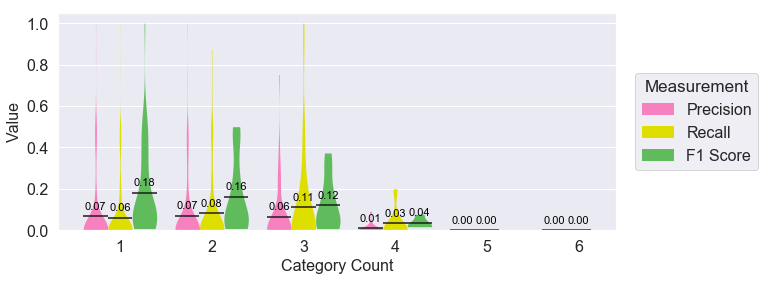

In [19]:
# recall and precision aganist category
def precision_recall_categorycount(technique):
    ax = fancy_pr_plot('Category Count', rtf(rcpr, technique))
    process_fig(ax, 'recall-precision-categorycount', technique, False, 'Measurement', labels=pr_labels, fontsize=11)
    
for technique in techniques:
    precision_recall_categorycount(technique)

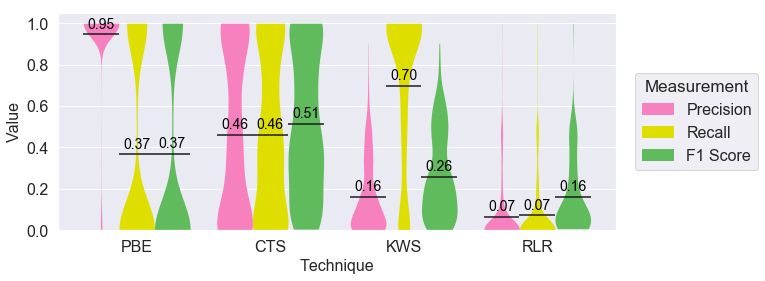

In [20]:
# recall precision all techniques
ax = fancy_pr_plot('Technique', rcpr)
process_fig(ax, 'recall-precision', 'all', False, 'Measurement', labels=pr_labels)

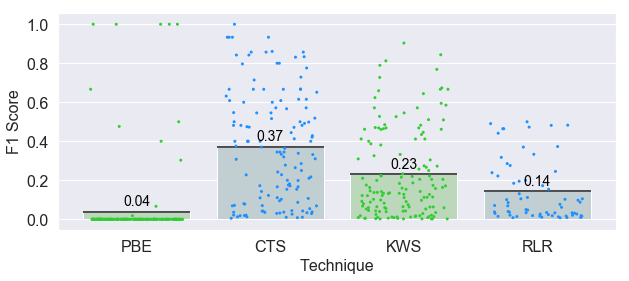

In [21]:
# F Score all
# single and multi in one figure
# f1_big = pd.melt(result_big,
#                    id_vars=['Example Count', 'Technique', 'Category Count', 'Retrieval Size Factor', 'Test Category'],
#                    value_vars=['Precision', 'Recall'],
#                    var_name='Measurement',
#                    value_name='Value')
# rcpr_big
# rcpr = rcpr_big[rcpr_big['Retrieval Size Factor'] == 1]
# rcpr

ax = sns.barplot(x='Technique', y='F1 Score', data=result[result['Category Count'] != 1],
                 errcolor='coral',ci=None, capsize=0.1, errwidth=1,
                 saturation=0.3, palette=['palegreen','lightblue'])
sns.stripplot(x='Technique', y='F1 Score', data=result[result['Category Count'] != 1],
              dodge=True, color='grey', size=3, jitter=0.35,
              palette=['limegreen', 'dodgerblue'])
process_fig(ax, 'f1-score', 'all', False, '')

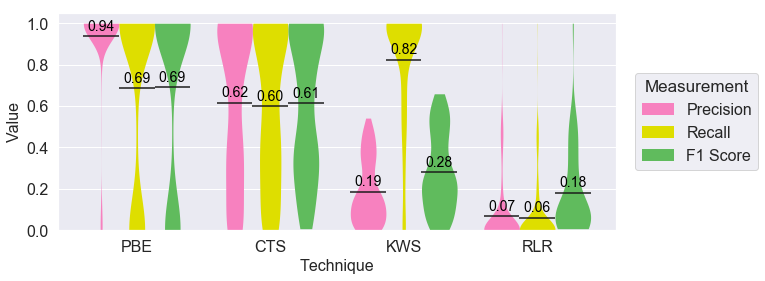

In [22]:
ax = fancy_pr_plot('Technique', rcpr[rcpr['Category Count'] == 1])
# ax = sns.barplot(x='Technique', y='Value', hue='Measurement', data=rcpr[rcpr['Category Count'] == 1],
#                  errcolor='coral',ci=None, capsize=0.1, errwidth=1,
#                  saturation=0.3, palette=['palegreen','lightblue'])
# sns.stripplot(x='Technique', y='Value', hue='Measurement', data=rcpr[rcpr['Category Count'] == 1],
#               dodge=True, color='grey', size=3, jitter=0.35,
#               palette=['limegreen', 'dodgerblue'])
process_fig(ax, 'recall-precision-singlecategory', 'all', False, 'Measurement', labels=pr_labels)

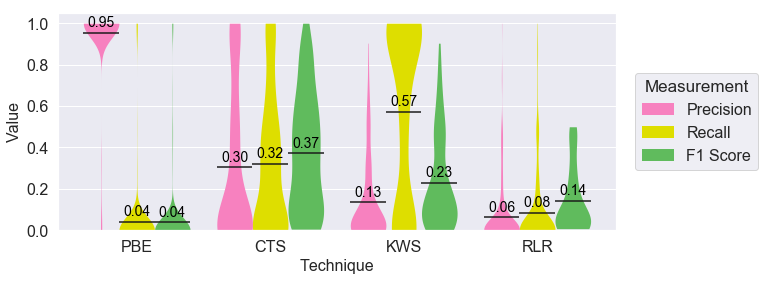

In [23]:
ax = fancy_pr_plot('Technique', rcpr[rcpr['Category Count'] > 1])
# ax = sns.barplot(x='Technique', y='Value', hue='Measurement', data=rcpr[rcpr['Category Count'] > 1],
#                  errcolor='coral',ci=None, capsize=0.1, errwidth=1,
#                  saturation=0.3, palette=['palegreen','lightblue'])
# sns.stripplot(x='Technique', y='Value', hue='Measurement', data=rcpr[rcpr['Category Count'] > 1],
#               dodge=True, color='grey', size=3, jitter=0.35,
#               palette=['limegreen', 'dodgerblue'])
process_fig(ax, 'recall-precision-multicategory', 'all', False, 'Measurement', labels=pr_labels)

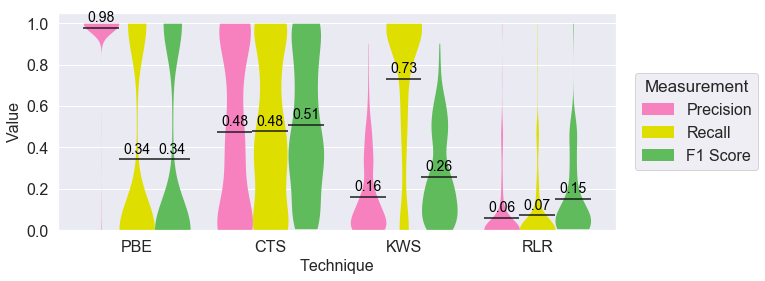

In [24]:
ax = fancy_pr_plot('Technique', rcpr[rcpr['Example Count'] > 1])
# ax = sns.barplot(x='Technique', y='Value', hue='Measurement', data=rcpr[rcpr['Example Count'] > 1],
#                  errcolor='coral',ci=None, capsize=0.1, errwidth=1,
#                  saturation=0.3, palette=['palegreen','lightblue'])
# sns.stripplot(x='Technique', y='Value', hue='Measurement', data=rcpr[rcpr['Example Count'] > 1],
#               dodge=True, color='grey', size=3, jitter=0.35,
#               palette=['limegreen', 'dodgerblue'])
process_fig(ax, 'recall-precision-mulitexample', 'all', False, 'Measurement', labels=pr_labels)

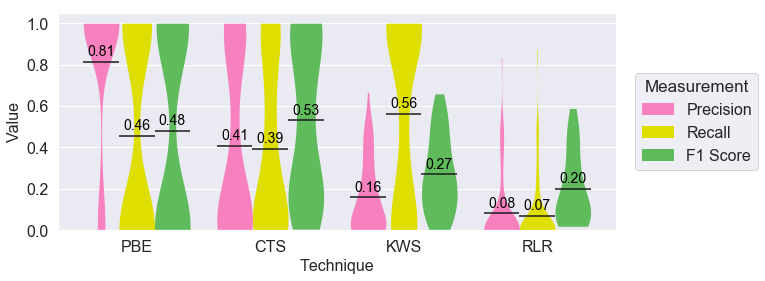

In [25]:
ax = fancy_pr_plot('Technique', rcpr[rcpr['Example Count'] == 1])
# ax = sns.barplot(x='Technique', y='Value', hue='Measurement', data=rcpr[rcpr['Example Count'] == 1],
#                  errcolor='coral',ci=None, capsize=0.1, errwidth=1,
#                  saturation=0.3, palette=['palegreen','lightblue'])
# sns.stripplot(x='Technique', y='Value', hue='Measurement', data=rcpr[rcpr['Example Count'] == 1],
#               dodge=True, color='grey', size=3, jitter=0.35,
#               palette=['limegreen', 'dodgerblue'])
process_fig(ax, 'recall-precision-singleexample', 'all', False, 'Measurement', labels=pr_labels)

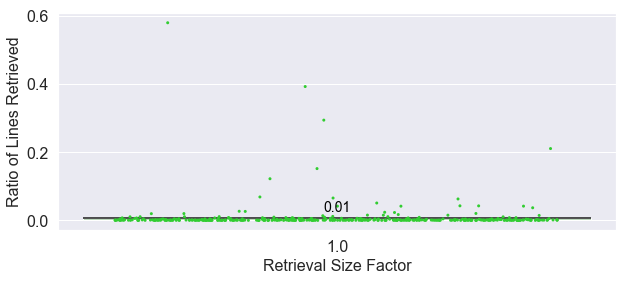

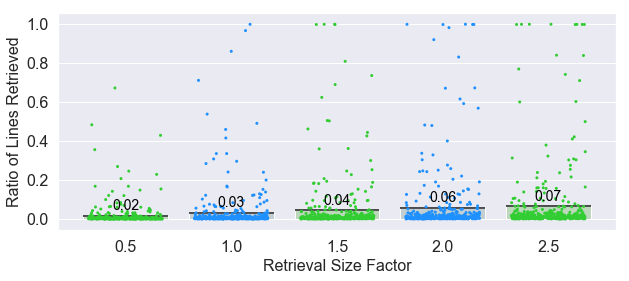

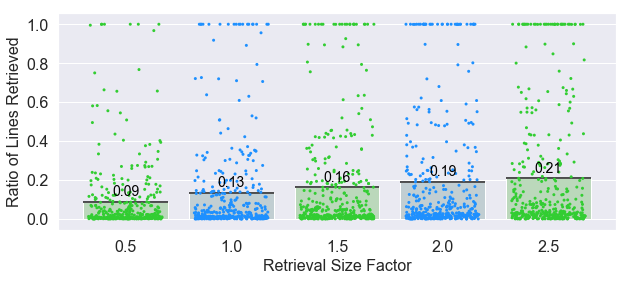

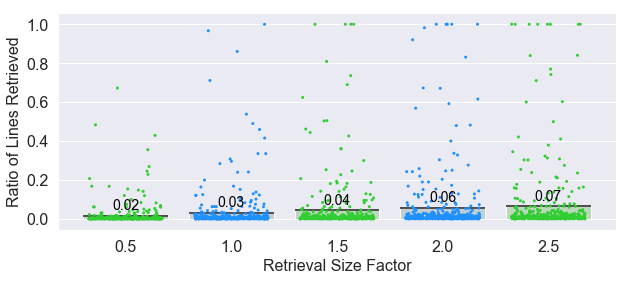

In [26]:
def retrieval_ratio_size_factor(technique):
    ax = sns.barplot(x='Retrieval Size Factor', y='Ratio of Lines Retrieved', data=rtf(result_big, technique),
                     errcolor='coral',ci=None, capsize=0.1, errwidth=1,
                     saturation=0.3, palette=['palegreen','lightblue'])
    sns.stripplot(x='Retrieval Size Factor', y='Ratio of Lines Retrieved', data=rtf(result_big, technique),
                  dodge=True, color='grey', size=3, jitter=0.35,
                  palette=['limegreen', 'dodgerblue'])
    process_fig(ax, 'retrievalsizefactor-retrievalratio', technique, False, '')

for technique in techniques:
    retrieval_ratio_size_factor(technique)

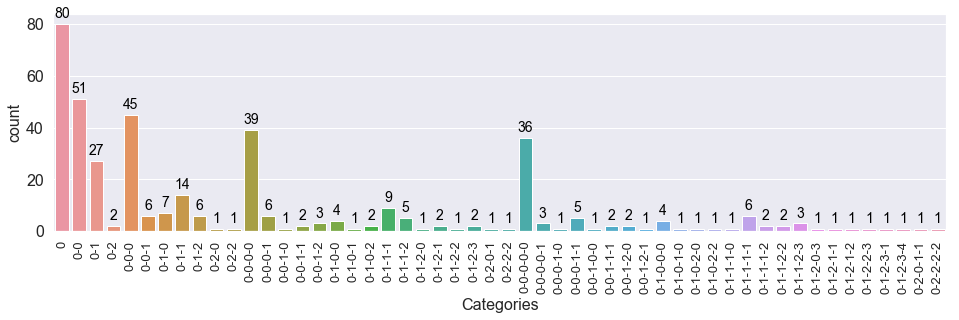

In [27]:
# category distribution
pbe_result = rtf(result, 'PBE')
plt.figure(figsize=(16,4))
order = list(set(pbe_result['Categories']))
order.sort()
order.sort(key = len)
ax = sns.countplot(x='Categories', data=pbe_result, order=order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=13, horizontalalignment='center')
process_fig(ax, 'categories', 'dataset', True, '')

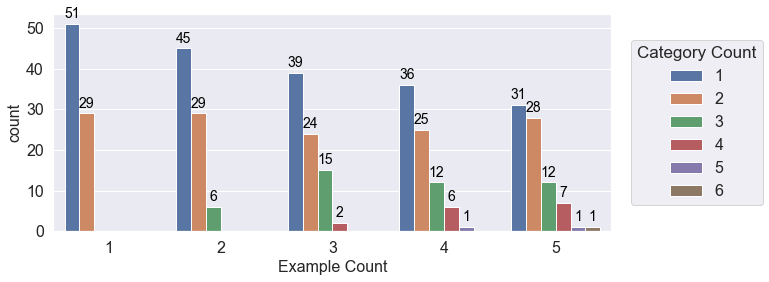

In [28]:
# category count
ax = sns.countplot(x='Example Count', hue='Category Count', data=rtf(result, 'PBE'))
process_fig(ax, 'categorycount-examplecount', 'dataset', True, 'Category Count')

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



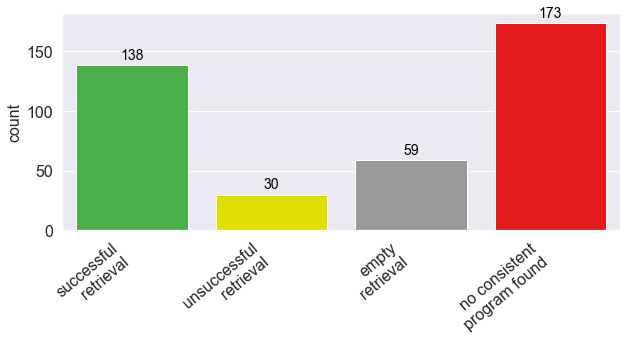

In [29]:
# pbe: if the extraction failed, why did it fail? (when was no program learned/regex did not match?)
# failed = result[(result['All Desired Lines Extracted'] == False) & (result.Technique == 'PBE')]
# failed_pbe = failed
failed = rtf(result, 'PBE')
failed.loc[failed['Test Output'].isin(['no program found', 'no extraction found for this input']), 'to'] = failed['Test Output']
failed.loc[~failed['Test Output'].isin(['no program found', 'no extraction found for this input']), 'to'] = 'unsuccessful\nretrieval'
failed.loc[(failed['to'] == 'unsuccessful\nretrieval') & (failed['All Desired Lines Extracted'] == True), 'to'] = 'successful\nretrieval'
failed.loc[failed['to'] == 'no extraction found for this input', 'to'] = 'empty\nretrieval'
failed.loc[failed['to'] == 'no program found', 'to'] = 'no consistent\nprogram found'
pbe_fail_order = ['successful\nretrieval', 'unsuccessful\nretrieval', 'empty\nretrieval', 'no consistent\nprogram found']
pbe_fail_palette = ['#4daf4a', '#dede00', '#999999', '#e41a1c']

ax = sns.countplot(x="to",
                   data=failed, order=pbe_fail_order,
                   palette=pbe_fail_palette , saturation=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_xlabel('')
process_fig(ax, 'failure-reason', 'PBE', True, '')

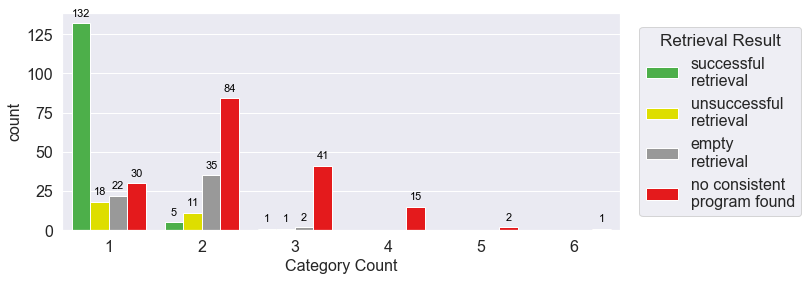

In [30]:
# pbe failure reason against category count
ax = sns.countplot(x='Category Count', hue='to', data=failed, hue_order=pbe_fail_order,
                   palette=pbe_fail_palette , saturation=1)
process_fig(ax, 'failure-reason-categorycount', 'PBE', True, 'Retrieval Result', fontsize=11)

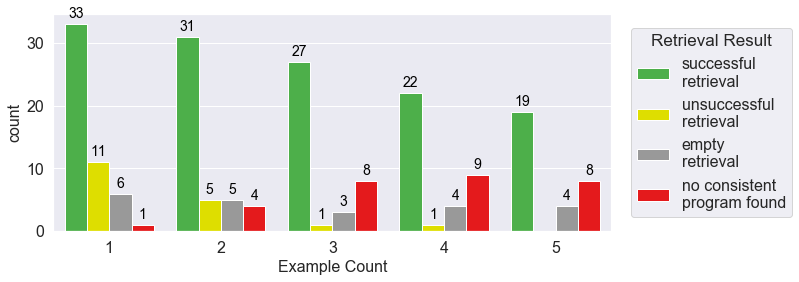

In [31]:
# pbe failure reason against example count
ax = sns.countplot(x='Example Count', hue='to', data=failed[failed['Category Count'] == 1], hue_order=pbe_fail_order,
                   palette=pbe_fail_palette , saturation=1)
process_fig(ax, 'failure-reason-examplecount', 'PBE', True, 'Retrieval Result')

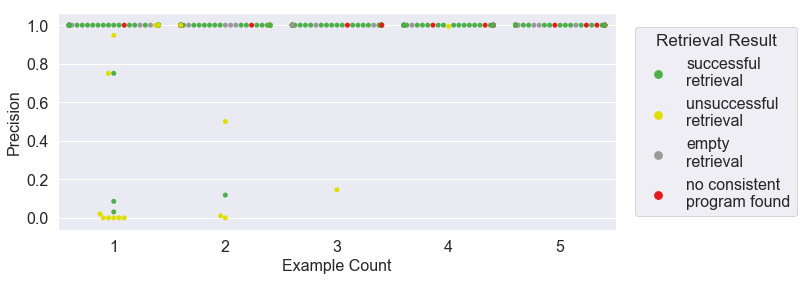

In [32]:
# precision one technique against example count
ax = sns.swarmplot(x='Example Count', y='Precision', hue='to', data=failed[failed['Category Count'] == 1], hue_order=pbe_fail_order,
                   palette=pbe_fail_palette)
process_fig(ax, 'precision-extraction-result', 'PBE', False, 'Retrieval Result')

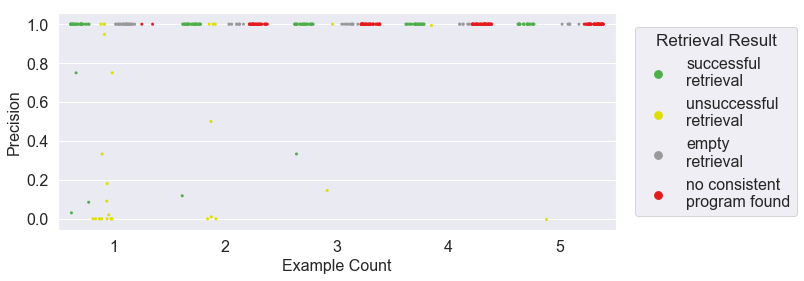

In [33]:
# precision one technique against example count
ax = sns.stripplot(x='Example Count', y='Precision', hue='to', data=failed, hue_order=pbe_fail_order,
                   dodge=True, size=3, jitter=0.35,
                   palette=pbe_fail_palette)
process_fig(ax, 'recall-extraction-result', 'PBE', False, 'Retrieval Result')

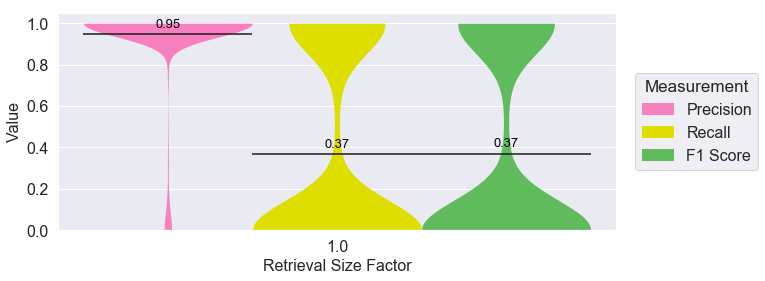

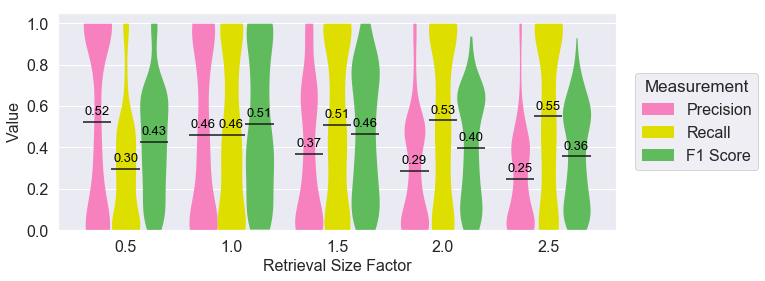

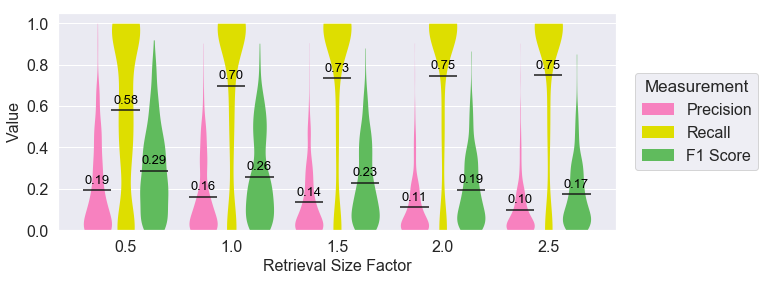

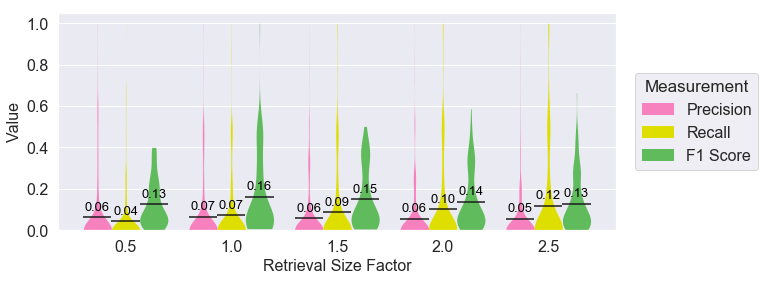

In [34]:
def recall_precision_contextsizefactor(technique):
    ax = fancy_pr_plot('Retrieval Size Factor', rtf(rcpr_big, technique))
#     ax = sns.barplot(x='Retrieval Size Factor', y='Value', hue='Measurement', data=rtf(rcpr_big, technique), errcolor='coral',
#                      ci=None, capsize=0.1, errwidth=1, saturation=0.3, palette=['palegreen','lightblue'])
#     sns.stripplot(x='Retrieval Size Factor', y='Value', hue='Measurement', data=rtf(rcpr_big, technique),
#                   dodge=True, color='grey', size=3, jitter=0.35, palette=['limegreen', 'dodgerblue'])
    process_fig(ax, 'contextsizefactor-precision-recall', technique, False, 'Measurement', labels=pr_labels, fontsize=13)

for technique in techniques:
    recall_precision_contextsizefactor(technique)

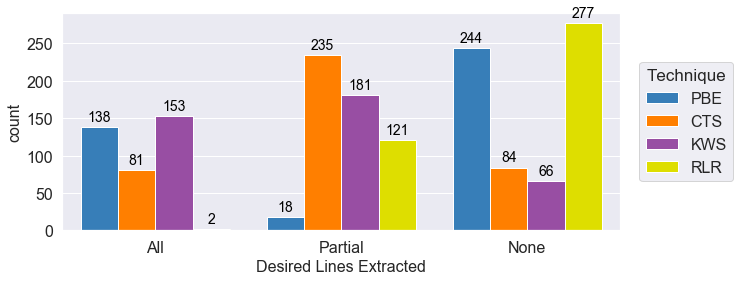

In [35]:
rr = result
rr.loc[result['Recall'] == 1, 'Desired Lines Extracted'] = 'All'
rr.loc[result['Recall'] == 0, 'Desired Lines Extracted'] = 'None'
rr.loc[(result['Recall'] != 1) & (result['Recall'] != 0), 'Desired Lines Extracted'] = 'Partial'

ax = sns.countplot(x='Desired Lines Extracted', hue='Technique', data=rr, order=['All', 'Partial', 'None'],
                   palette=['#377eb8', '#ff7f00', '#984ea3', '#dede00'], saturation=1)
process_fig(ax, 'success-partial', 'all', True, 'Technique')

In [71]:
pd.set_option('display.max_colwidth', -1)
rtf(rr[rr['Desired Lines Extracted'] == 'Partial'], 'PBE').filter(['Test Output', 'Desired Test Output']).iloc[4]

Test Output            Error: Invalid CSS after "2.3em": expected expression (e.g. 1px, bold), was ";"\n        on line 86 of sass/components/dropdown.sass                                                                                     
Desired Test Output    Error: Invalid CSS after "2.3em": expected expression (e.g. 1px, bold), was ";"\n        on line 86 of sass/components/dropdown.sass\n        from line 5 of sass/components/_all.sass\n        from line 6 of bulma.sass
Name: 71, dtype: object

In [ ]:
ax = sns.countplot(x='Technique', data=result[result['Recall'] == 1],
                   palette=['#377eb8', '#ff7f00', '#984ea3', '#dede00'], saturation=1)
process_fig(ax, 'recall-one', 'all', True, '')

In [ ]:
ax = sns.countplot(x='Technique', data=result[result['Recall'] == 0],
                   palette=['#377eb8', '#ff7f00', '#984ea3', '#dede00'], saturation=1)
process_fig(ax, 'recall-zero', 'all', True, '')

In [ ]:
ax = sns.countplot(x='Technique', data=result[(result['Recall'] != 1) & (result['Recall'] != 0)],
                   palette=['#377eb8', '#ff7f00', '#984ea3', '#dede00'], saturation=1)
process_fig(ax, 'recall-notonenotzero', 'all', True, '')

In [ ]:
# all
np.array([138, 81, 153, 2]) / 400

In [ ]:
# partial
np.array([18, 235, 181, 121]) / 400

In [ ]:
# none
np.array([244, 84, 66, 277]) / 400

In [38]:
r6 = result[result['Category Count'] == 6]
#r6.dtypes
r6.filter(['Categories', 'Category Count', 'Test Category'])

,Categories,Category Count,Test Category
284,0-1-2-3-4,6,5
284,0-1-2-3-4,6,5
284,0-1-2-3-4,6,5
284,0-1-2-3-4,6,5


In [ ]:
ax = sns.lineplot(x='False Positive Rate', y='Recall', hue='Technique', data=result)

In [ ]:
ax = sns.lineplot(x='False Positive Rate', y='Recall', data=rtf(result, 'RLR'))